In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

2024-08-06 14:59:38.669678: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 14:59:38.721548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 14:59:39.457229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [3]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/MobileNet'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Parameters
img_height, img_width = 224, 224  # ResNet50 requires images of size 224x224
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [5]:
# Function to create train, validation, and test splits
def create_splits():
    try:
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
    
        for class_name in os.listdir(dataset_dir):        
            train_class_path = os.path.join(train_dir, class_name)        
            if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)        
            
            test_class_path = os.path.join(test_dir, class_name)        
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)        
    
            validation_class_dir = os.path.join(validation_dir, class_name)       
            if not os.path.exists(validation_class_dir):
                os.makedirs(validation_class_dir)        
        
        for class_name in os.listdir(dataset_dir):        
            class_path = os.path.join(dataset_dir, class_name)
            
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)
                train_split = int(train_ratio * len(images))
                validation_split = int(validation_ratio * len(images))
                
                train_images = images[:train_split]
                validation_images = images[train_split:train_split + validation_split]
                test_images = images[train_split + validation_split:]
    
                for image in train_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
                for image in validation_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
                for image in test_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))
    except Exception as err:
        print("Error:", str(err))

In [6]:
# Split the dataset
create_splits()

In [7]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1083 images belonging to 5 classes.
Found 230 images belonging to 5 classes.
Found 239 images belonging to 5 classes.


In [10]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-08-06 14:59:41.511897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45810 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


17225924/17225924 [==============================] - 52s 3us/step


In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-08-06 15:00:38.591117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-08-06 15:00:38.855515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-06 15:00:38.904512: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd5ea767e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-06 15:00:38.904540: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-08-06 15:00:38.909194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-06 15:00:39.071554: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

33/33 [==============================] - ETA: 0s - loss: 1.9686 - accuracy: 0.1931

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 405ms/step - loss: 1.9686 - accuracy: 0.1931 - val_loss: 1.8459 - val_accuracy: 0.2143
Epoch 2/50
33/33 [==============================] - 14s 412ms/step - loss: 1.9262 - accuracy: 0.1931 - val_loss: 1.7644 - val_accuracy: 0.2009
Epoch 3/50
33/33 [==============================] - 14s 412ms/step - loss: 1.8532 - accuracy: 0.2284 - val_loss: 1.7227 - val_accuracy: 0.1964
Epoch 4/50
33/33 [==============================] - 13s 402ms/step - loss: 1.7948 - accuracy: 0.2550 - val_loss: 1.6824 - val_accuracy: 0.2098
Epoch 5/50
33/33 [==============================] - 14s 417ms/step - loss: 1.7896 - accuracy: 0.2254 - val_loss: 1.6753 - val_accuracy: 0.1875
Epoch 6/50
33/33 [==============================] - 14s 411ms/step - loss: 1.7244 - accuracy: 0.2578 - val_loss: 1.6621 - val_accuracy: 0.2054
Epoch 7/50
33/33 [==============================] - 14s 419ms/step - loss: 1.7205 - accuracy: 0.2322 - val_loss: 1.6515 - val_accuracy: 0.2098
Epoch 8/50

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 74ms/step - loss: 1.6823 - accuracy: 0.2092
Test accuracy: 0.21


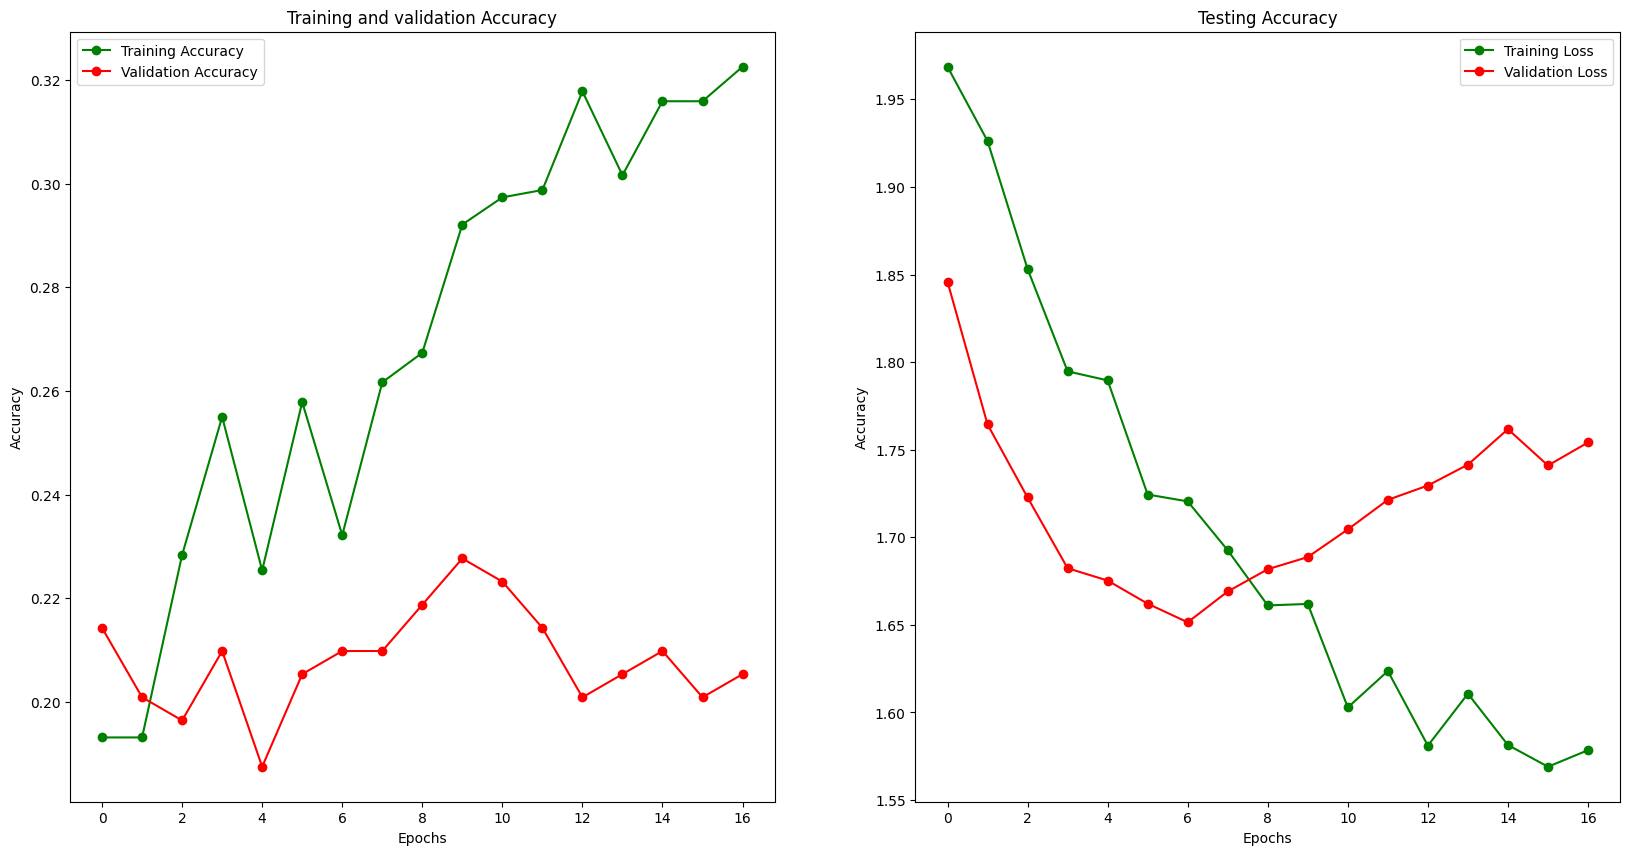

In [13]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 81ms/step


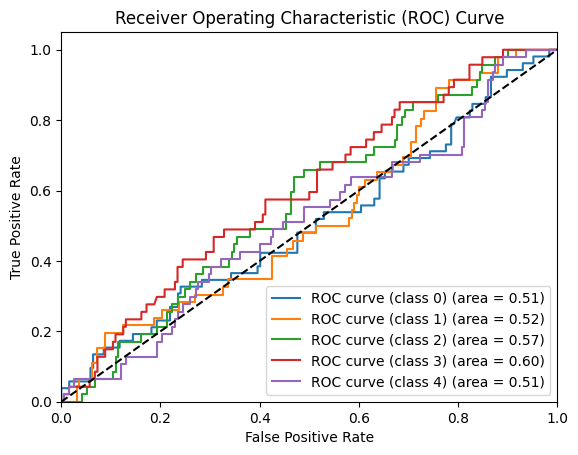

In [14]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 2

In [15]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8882 - accuracy: 0.2093

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 16s 407ms/step - loss: 1.8882 - accuracy: 0.2093 - val_loss: 1.6822 - val_accuracy: 0.2054
Epoch 2/50
33/33 [==============================] - 14s 413ms/step - loss: 1.8332 - accuracy: 0.2331 - val_loss: 1.6697 - val_accuracy: 0.2277
Epoch 3/50
33/33 [==============================] - 14s 422ms/step - loss: 1.8120 - accuracy: 0.2255 - val_loss: 1.6564 - val_accuracy: 0.2143
Epoch 4/50
33/33 [==============================] - 14s 410ms/step - loss: 1.7671 - accuracy: 0.2578 - val_loss: 1.6444 - val_accuracy: 0.2277
Epoch 5/50
33/33 [==============================] - 13s 405ms/step - loss: 1.7497 - accuracy: 0.2483 - val_loss: 1.6541 - val_accuracy: 0.2277
Epoch 6/50
33/33 [==============================] - 13s 402ms/step - loss: 1.6938 - accuracy: 0.2788 - val_loss: 1.6556 - val_accuracy: 0.2679
Epoch 7/50
33/33 [==============================] - 13s 407ms/step - loss: 1.7147 - accuracy: 0.2655 - val_loss: 1.6521 - val_accuracy: 0.2723
Epoch 8/50

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 72ms/step - loss: 1.6707 - accuracy: 0.2594
Test accuracy: 0.26


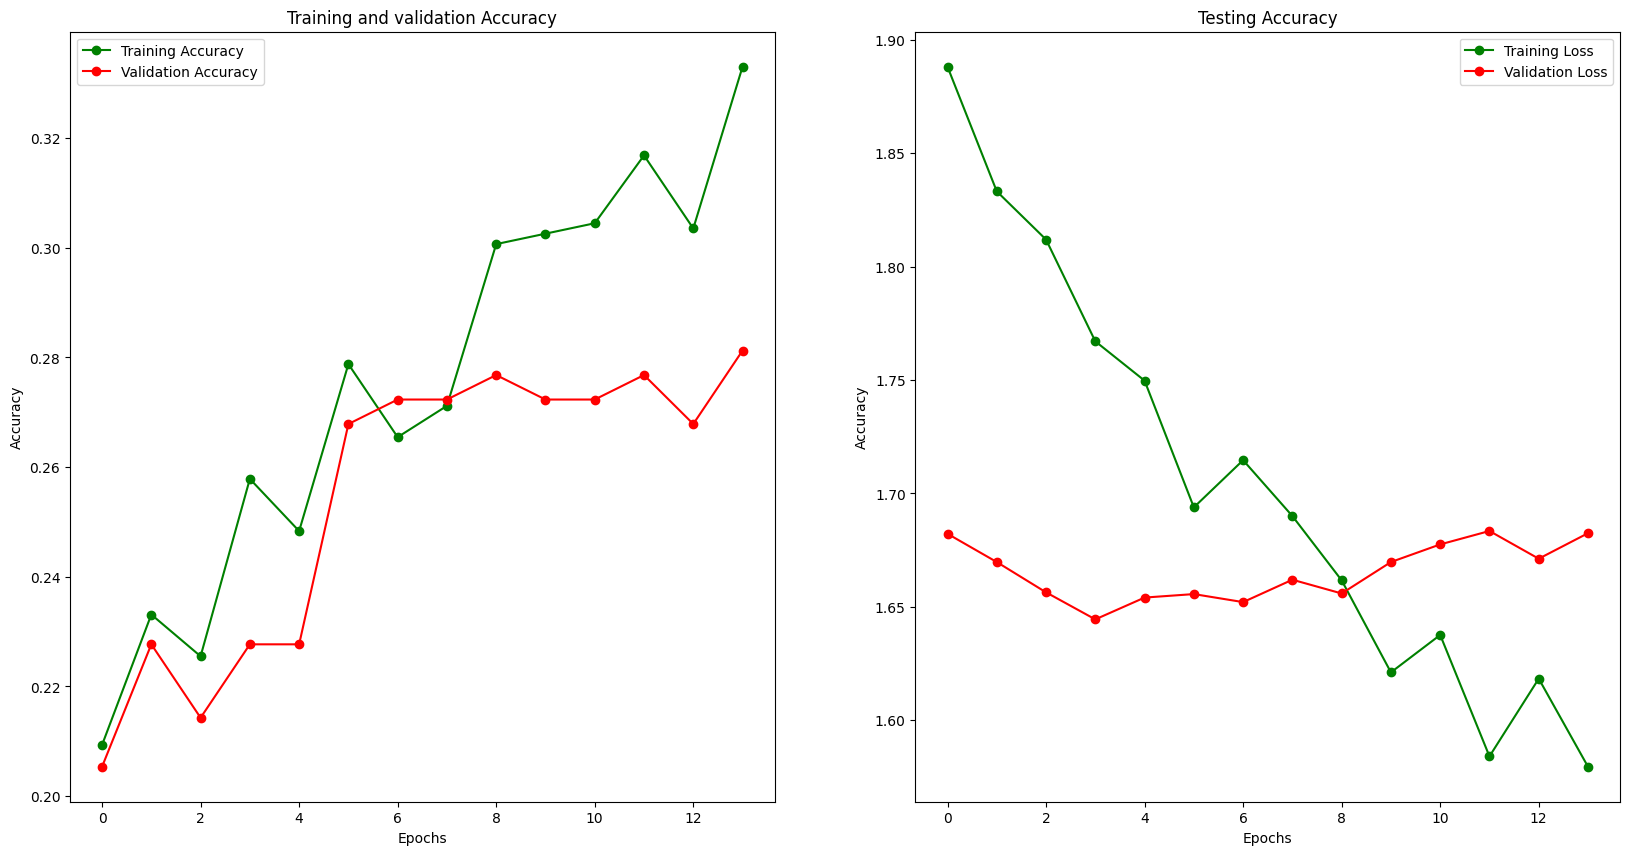

In [18]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 67ms/step


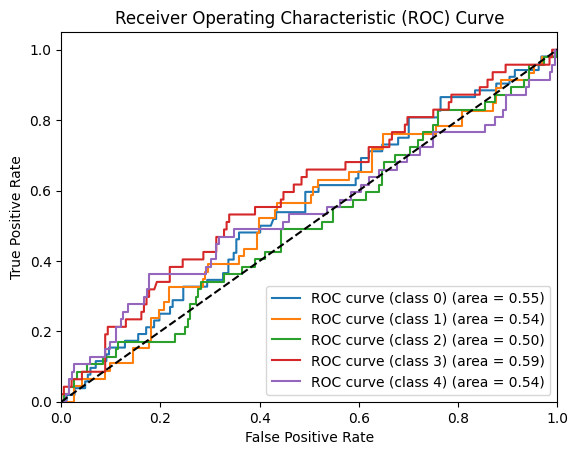

In [19]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 4

In [20]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8617 - accuracy: 0.2540

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 16s 404ms/step - loss: 1.8617 - accuracy: 0.2540 - val_loss: 1.7260 - val_accuracy: 0.2232
Epoch 2/50
33/33 [==============================] - 14s 415ms/step - loss: 1.6223 - accuracy: 0.3235 - val_loss: 1.6233 - val_accuracy: 0.2679
Epoch 3/50
33/33 [==============================] - 14s 414ms/step - loss: 1.5258 - accuracy: 0.3578 - val_loss: 1.6121 - val_accuracy: 0.2321
Epoch 4/50
33/33 [==============================] - 13s 402ms/step - loss: 1.5189 - accuracy: 0.3815 - val_loss: 1.6785 - val_accuracy: 0.2634
Epoch 5/50
33/33 [==============================] - 13s 405ms/step - loss: 1.4712 - accuracy: 0.3758 - val_loss: 1.7231 - val_accuracy: 0.2455
Epoch 6/50
33/33 [==============================] - 13s 406ms/step - loss: 1.3822 - accuracy: 0.4481 - val_loss: 1.7023 - val_accuracy: 0.2500
Epoch 7/50
33/33 [==============================] - 14s 409ms/step - loss: 1.3788 - accuracy: 0.4234 - val_loss: 1.6946 - val_accuracy: 0.2679
Epoch 8/50

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 67ms/step - loss: 1.5701 - accuracy: 0.2678
Test accuracy: 0.27


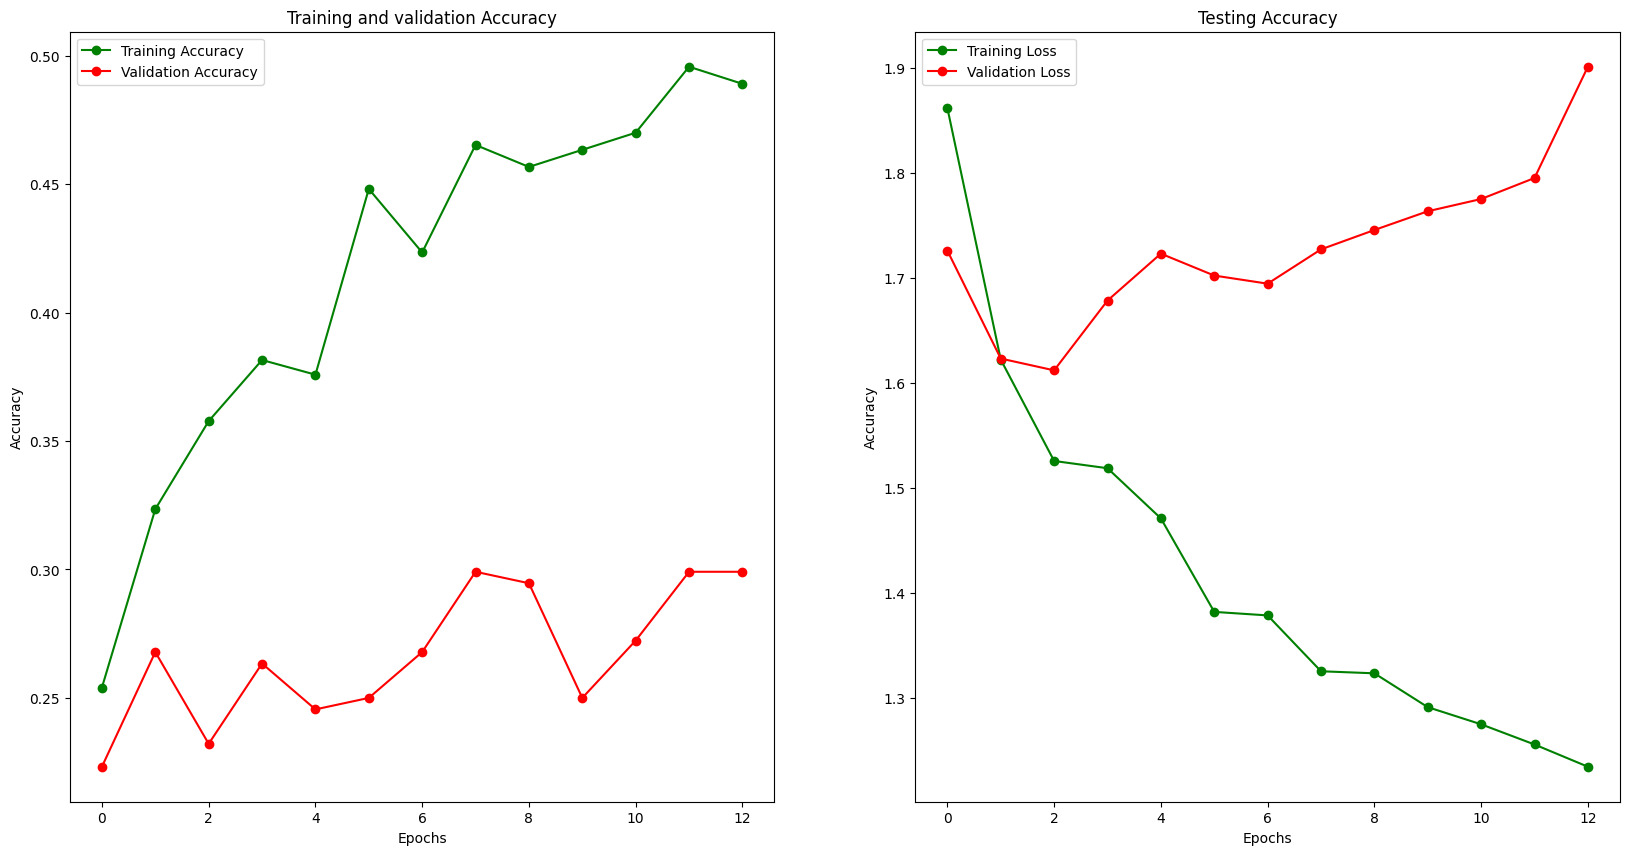

In [23]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 65ms/step


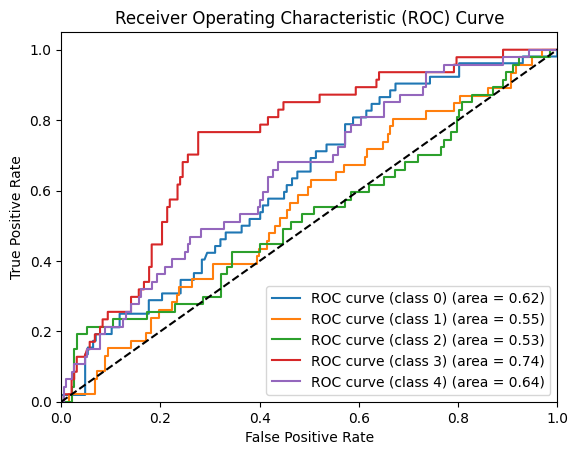

In [24]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Architecture No 5

In [25]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8550 - accuracy: 0.2274

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 16s 408ms/step - loss: 1.8550 - accuracy: 0.2274 - val_loss: 1.5883 - val_accuracy: 0.2857
Epoch 2/50
33/33 [==============================] - 14s 414ms/step - loss: 1.6294 - accuracy: 0.3187 - val_loss: 1.5431 - val_accuracy: 0.2902
Epoch 3/50
33/33 [==============================] - 14s 413ms/step - loss: 1.5440 - accuracy: 0.3597 - val_loss: 1.5539 - val_accuracy: 0.2902
Epoch 4/50
33/33 [==============================] - 14s 407ms/step - loss: 1.4747 - accuracy: 0.3968 - val_loss: 1.5522 - val_accuracy: 0.2857
Epoch 5/50
33/33 [==============================] - 13s 405ms/step - loss: 1.4371 - accuracy: 0.4006 - val_loss: 1.6857 - val_accuracy: 0.2589
Epoch 6/50
33/33 [==============================] - 13s 391ms/step - loss: 1.3900 - accuracy: 0.4443 - val_loss: 1.6442 - val_accuracy: 0.2812
Epoch 7/50
33/33 [==============================] - 13s 398ms/step - loss: 1.3686 - accuracy: 0.4405 - val_loss: 1.7440 - val_accuracy: 0.2902
Epoch 8/50

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 74ms/step - loss: 1.5846 - accuracy: 0.2594
Test accuracy: 0.26


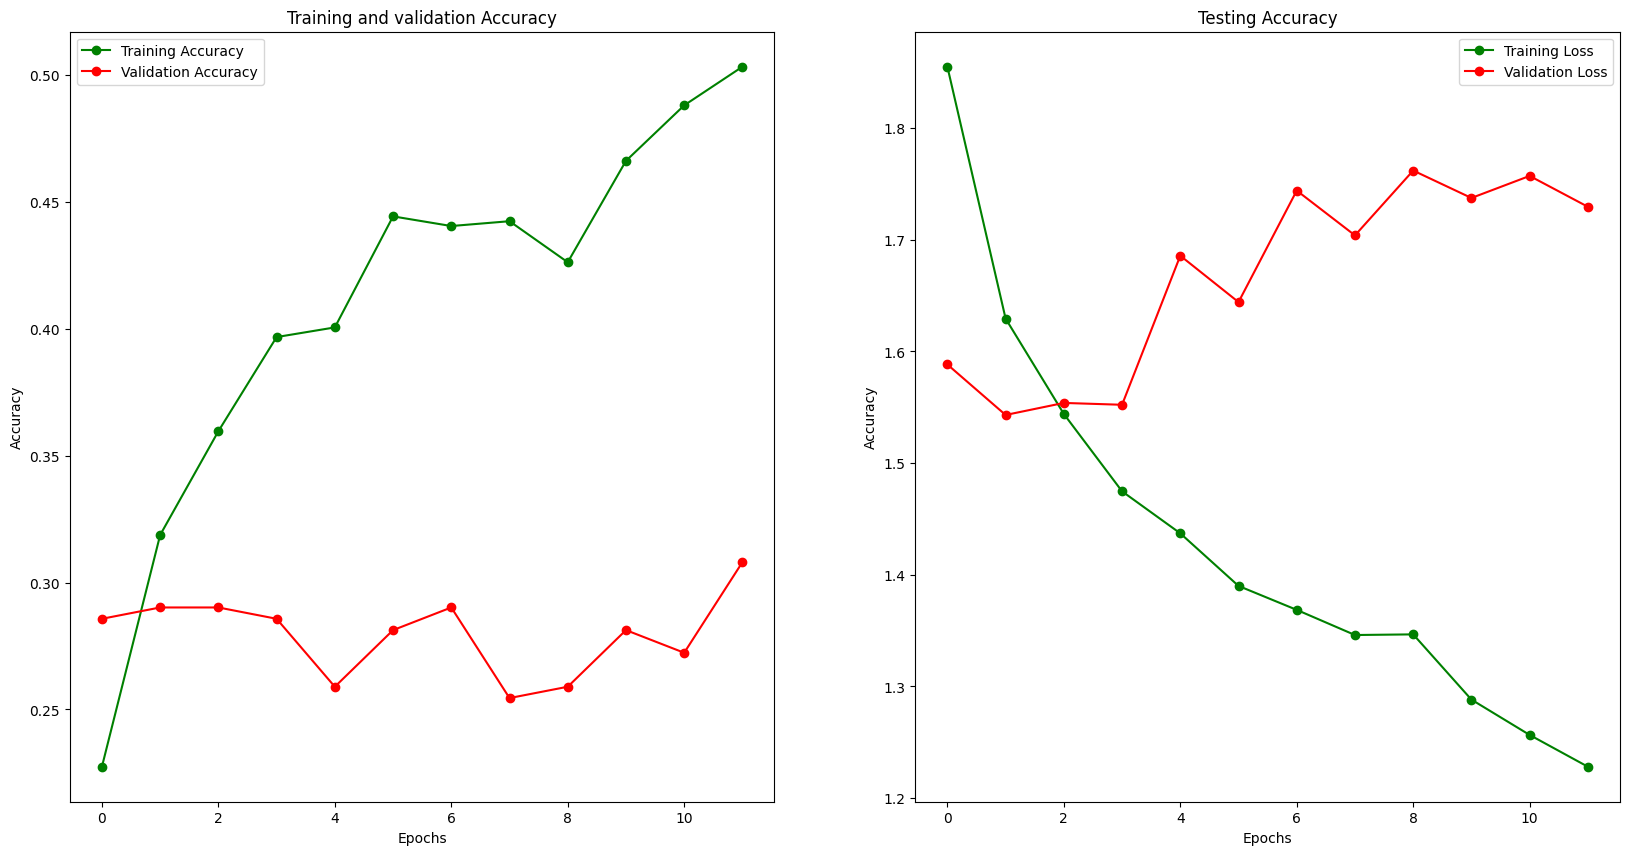

In [28]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 79ms/step


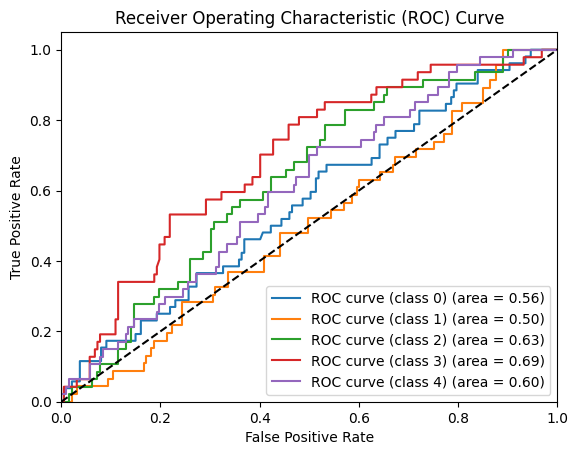

In [29]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 6

In [30]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8695 - accuracy: 0.2455

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 403ms/step - loss: 1.8695 - accuracy: 0.2455 - val_loss: 1.7306 - val_accuracy: 0.2455
Epoch 2/50
33/33 [==============================] - 14s 410ms/step - loss: 1.7632 - accuracy: 0.2493 - val_loss: 1.6900 - val_accuracy: 0.2500
Epoch 3/50
33/33 [==============================] - 14s 413ms/step - loss: 1.6506 - accuracy: 0.2950 - val_loss: 1.6742 - val_accuracy: 0.2232
Epoch 4/50
33/33 [==============================] - 14s 412ms/step - loss: 1.6191 - accuracy: 0.3092 - val_loss: 1.6340 - val_accuracy: 0.2366
Epoch 5/50
33/33 [==============================] - 13s 406ms/step - loss: 1.5815 - accuracy: 0.3083 - val_loss: 1.6671 - val_accuracy: 0.2455
Epoch 6/50
33/33 [==============================] - 14s 409ms/step - loss: 1.5278 - accuracy: 0.3644 - val_loss: 1.6503 - val_accuracy: 0.2589
Epoch 7/50
33/33 [==============================] - 13s 406ms/step - loss: 1.5150 - accuracy: 0.3568 - val_loss: 1.6394 - val_accuracy: 0.2768
Epoch 8/50

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 68ms/step - loss: 1.5652 - accuracy: 0.2636
Test accuracy: 0.26


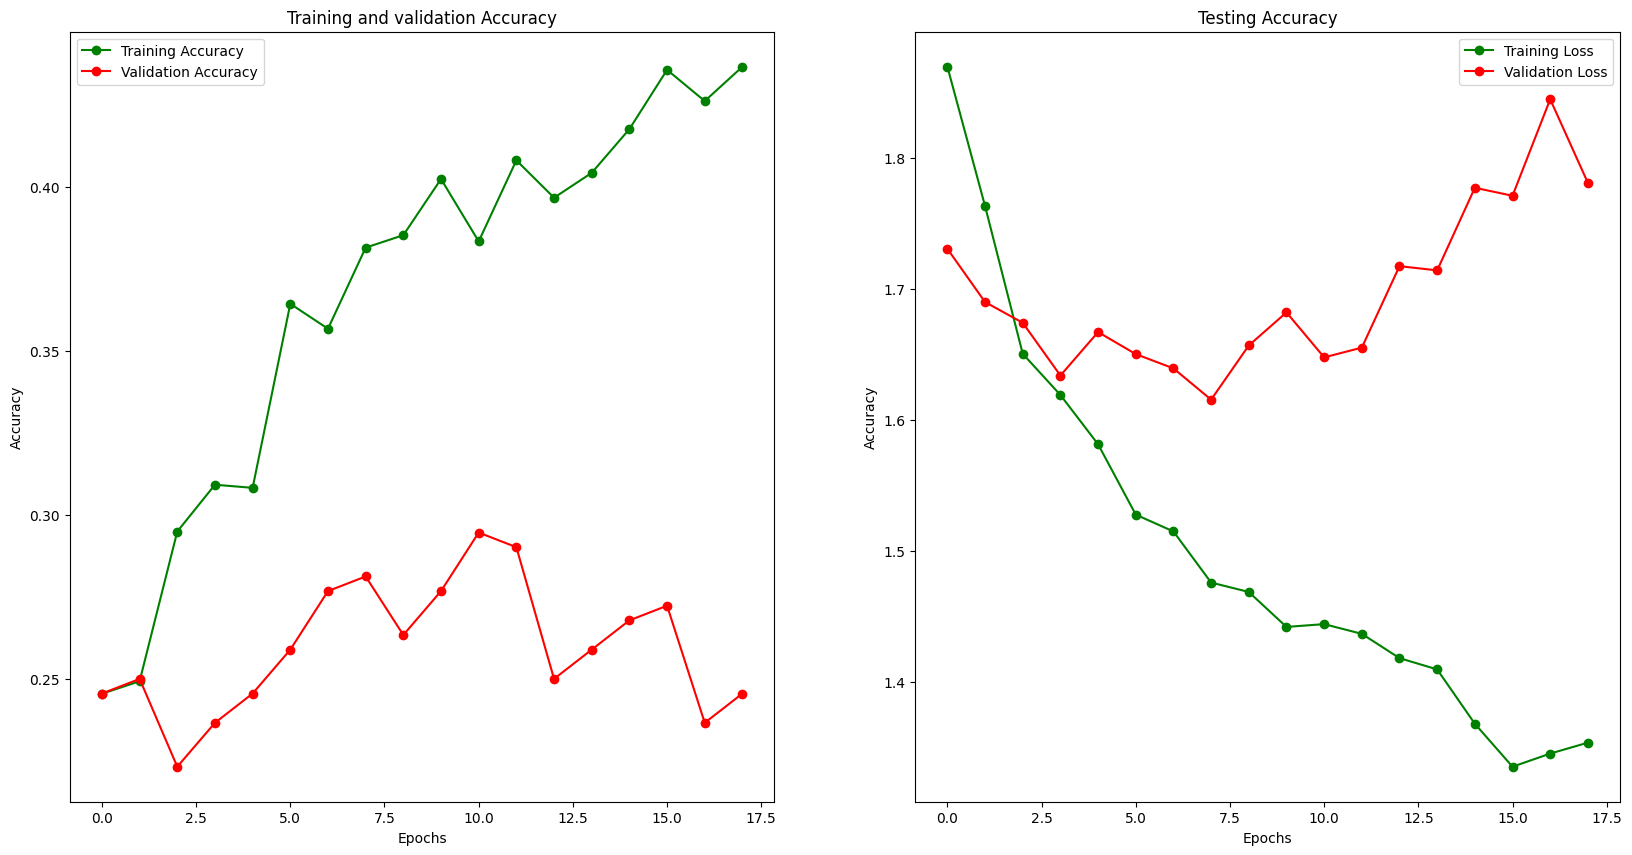

In [33]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 79ms/step


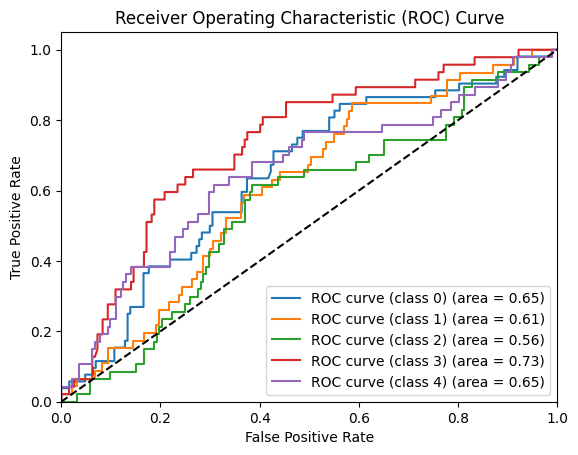

In [34]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 7

In [35]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [36]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8751 - accuracy: 0.2236

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 409ms/step - loss: 1.8751 - accuracy: 0.2236 - val_loss: 1.5673 - val_accuracy: 0.2589
Epoch 2/50
33/33 [==============================] - 13s 403ms/step - loss: 1.6352 - accuracy: 0.3130 - val_loss: 1.5737 - val_accuracy: 0.2500
Epoch 3/50
33/33 [==============================] - 14s 414ms/step - loss: 1.5621 - accuracy: 0.3501 - val_loss: 1.5395 - val_accuracy: 0.3125
Epoch 4/50
33/33 [==============================] - 14s 416ms/step - loss: 1.5250 - accuracy: 0.3825 - val_loss: 1.5252 - val_accuracy: 0.3036
Epoch 5/50
33/33 [==============================] - 14s 408ms/step - loss: 1.4381 - accuracy: 0.4034 - val_loss: 1.5429 - val_accuracy: 0.2857
Epoch 6/50
33/33 [==============================] - 13s 402ms/step - loss: 1.4198 - accuracy: 0.4177 - val_loss: 1.5623 - val_accuracy: 0.2857
Epoch 7/50
33/33 [==============================] - 13s 402ms/step - loss: 1.4074 - accuracy: 0.4244 - val_loss: 1.5774 - val_accuracy: 0.3080
Epoch 8/50

In [37]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 72ms/step - loss: 1.5423 - accuracy: 0.3013
Test accuracy: 0.30


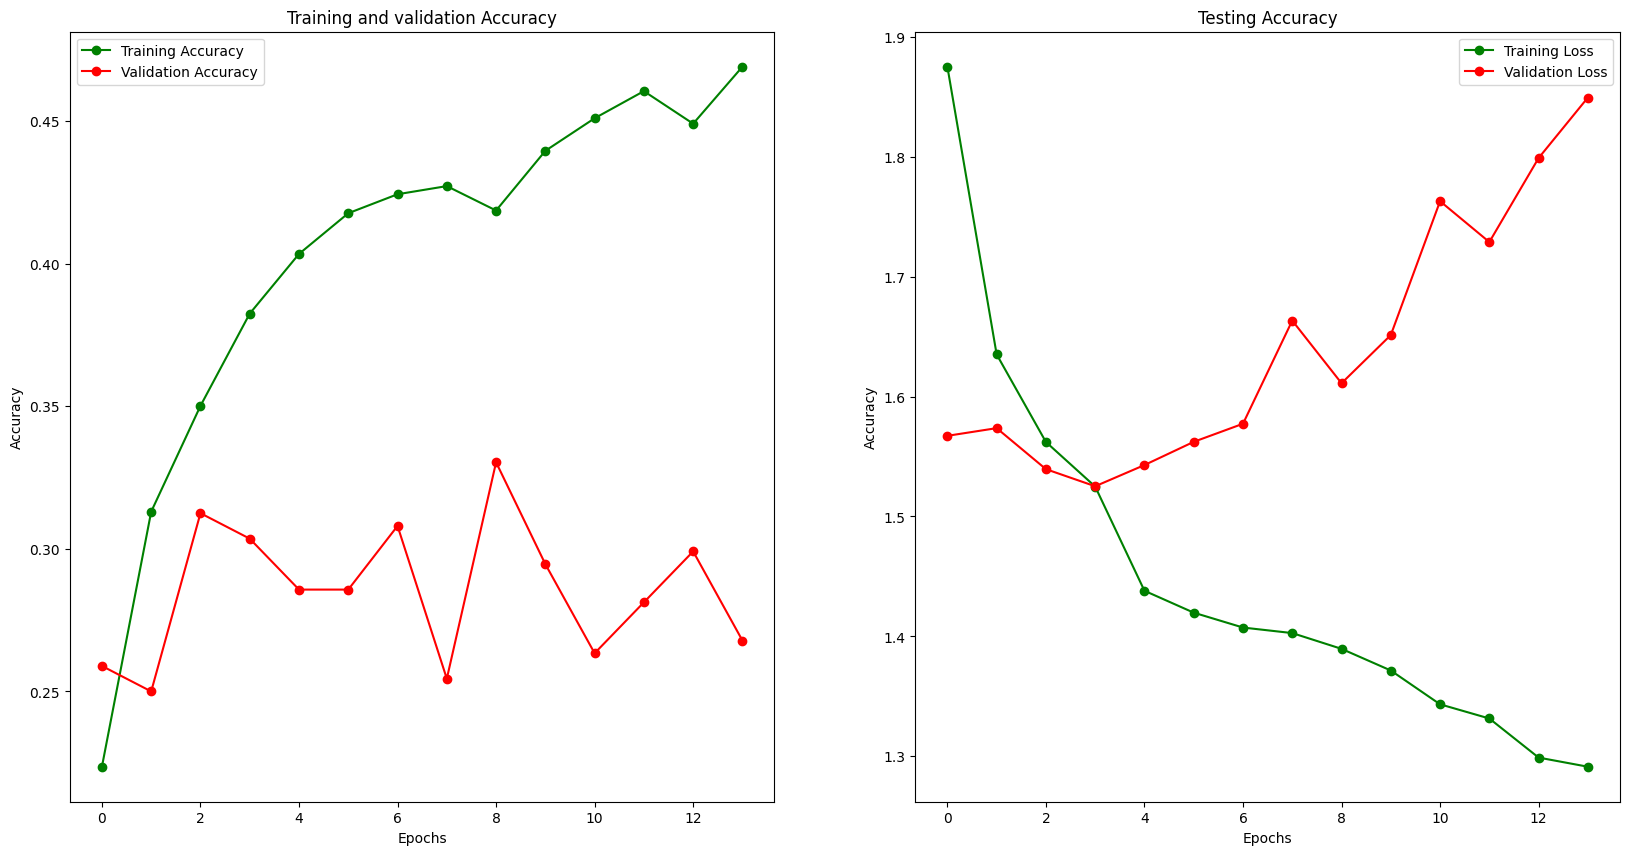

In [38]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 71ms/step


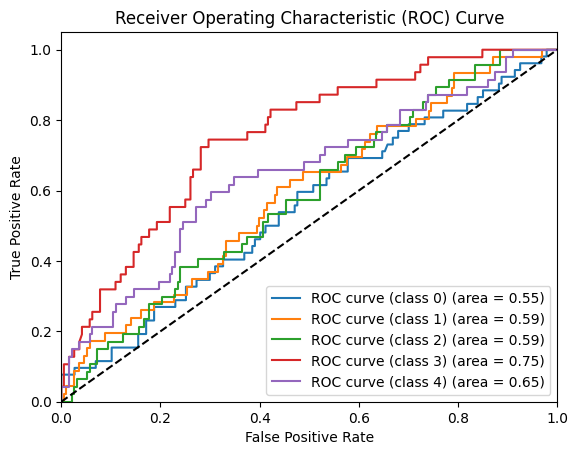

In [39]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
